# Лабораторная работа 3  
## Восстановление фазы несущей с линейной модуляцией
Выполнила: Шаповалова Виктория, ИКТ-11М.  

### 1. Импорт библиотек  
В данном разделе импортируются библиотеки, которые будут использоваться в ходе выполнения работы.

In [56]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import scipy
from scipy import signal
from scipy.signal import max_len_seq
from ModulationPy import PSKModem
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import upfirdn
from matplotlib.gridspec import GridSpec

### 2. Задание параметров  
В данном разделе задаются параметры, которые будут использованы в ходе выполнения работы.

In [57]:
random.seed(1)
psk_shift = np.pi/4  # Поворот созвездия
data_len = 10000  # Длина информационной последовательности
offset_freq = 10000 # смещение по частоте
offset_phase = np.pi/4
fs = 1e8 
sps = 10
snr = 30
b_len = 100  # Длина буфера для суммы
order = 4

### 3. Генерация случайного сигнала  
В данном разделе с помощью функции рандома генерируется информационный сигнал длины data_len для дальнейшей передачи.

In [58]:
data = np.random.randint(0,4, size=data_len)

### 4. QPSK-модуляция
В данном разделе задается psk-модуляция. Для данной работы выбрана qpsk-модуляция.

Text(0.5, 0, 'Реальная часть')

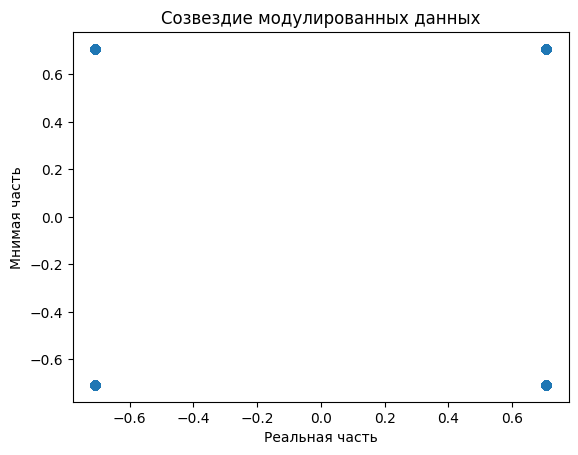

In [59]:
pskmodem = PSKModem(order, psk_shift, 
                 bin_input=False,
                 soft_decision=False,
                 bin_output=False)

data_mod = pskmodem.modulate(data) 

plt.figure(1)
plt.scatter(np.real(data_mod),np.imag(data_mod))
plt.title('Созвездие модулированных данных')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")



### 5. Фазовый сдвиг  
В данном разделе реализован сдвиг по фазе. Он задается параметром offset_phase. Для данного случая сдвиг равен pi/4.

Text(0.5, 1.0, 'Созвездие сигнала с фазовым сдвигом')

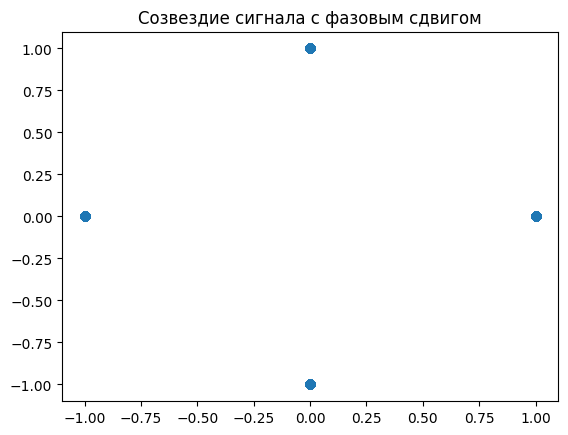

In [60]:
def phase_offset_func(data, phase):
    data = data * np.exp(1j*phase) 
    return data

data_mod_phaseof = phase_offset_func(data_mod, offset_phase)

plt.figure(1)
plt.scatter(np.real(data_mod_phaseof), np.imag(data_mod_phaseof))
plt.title("Созвездие сигнала с фазовым сдвигом")


### 6. Добавление АБГШ 
К сдвинутому сигналу добавляется АБГШ, который создается функцией awgn. Входным параметром задается отношение сигнал/шум в дБ. В данном примере оно задано 30 дБ.

Text(0.5, 0, 'Реальная часть')

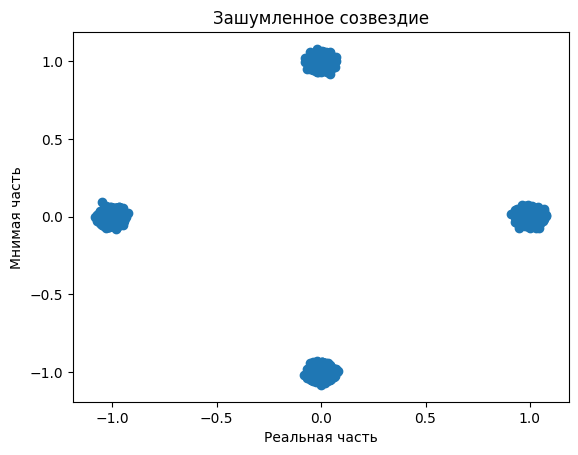

In [61]:
def awgn(signal, snr):
    sig_power = np.mean(np.abs(signal)**2) # calculate signal power
    sig_power_db = 10* np.log10(sig_power) # convert to dB

    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(signal)) + \
                                            np.random.randn(len(signal))*1j)

    return complex_noise

awgn_noise = awgn(data_mod_phaseof, snr)
tx = data_mod_phaseof + awgn_noise

plt.figure(1)
plt.scatter(tx.real, tx.imag)
plt.title('Зашумленное созвездие')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")


### 7. Добавление схемы, не относящейся к петле Костаса
На приемной стороне должна быть применена схема, восстанавливающая частотное и фазовое отклонение. В качестве такой схемы, не относящейся к типу схем петли Костаса, выбрана схема ML data-aided phase estimation, показанная на рисунке ниже.  
На входе схемы выборки из согласованного фильтра отбираются со скоростью 2/T, и последовательно-параллельный преобразователь (S/P) разделяет последовательности {x(k)} и {x(k +1/2)}, которые домножаются на соответствующий коэффициент и суммируются. На выходе определяется значение угла отклонения фазы.

![lab3_1.JPG](lab3_1.JPG)

Формула оценки смещения фазы несущей:
$$ \hat \theta = arg\{ \sum_{k=0}^{L_0-1}a_kx(k) - j\sum_{k=0}^{L_0-1}b_kx(k) \} $$


In [62]:
def ml_est(tx, data_mod, PHASE_EST):
    buf_counter = 0
    sum = 0

    for k in range(len(tx)):
        re_x = np.real(data_mod[k]) * tx[k]
        im_x = (-1j) * np.imag(data_mod[k]) * tx[k]
        sum += (re_x + im_x)
        buf_counter += 1
        if buf_counter == b_len:
            theta = np.angle(sum, deg=True)
            PHASE_EST = np.append(PHASE_EST, theta)
            buf_counter = 0
            sum = 0
    return(PHASE_EST)

PHASE_EST = np.array([]) 
PHASE_EST = ml_est(tx, data_mod, PHASE_EST)

print("Среднее значение смещения фазы: ", np.round(np.mean(PHASE_EST), decimals=3), "°")
print("Ошибка вычисления фазы: ",np.round(np.rad2deg(offset_phase)-np.mean(PHASE_EST), decimals=3), "°")



Среднее значение смещения фазы:  44.987 °
Ошибка вычисления фазы:  0.013 °


### 8. Добавление схемы петли Костаса  
Второй вариант борьбы с частотной и фазовой рассинхронизацией - применение схемы петли Костаса.   
Схема петли Костаса состоит из блоков фазового детектора, петлевого фильтра и локального генератора. Для данной функции выбран фазовый детектор, вычисляющий разность фаз между входным отсчетом и ближайшей опорной точкой созвездия. Петлевой фильтр заменяется подбором коэффициентов alpha и beta.

Text(0.5, 0, 'Реальная часть')

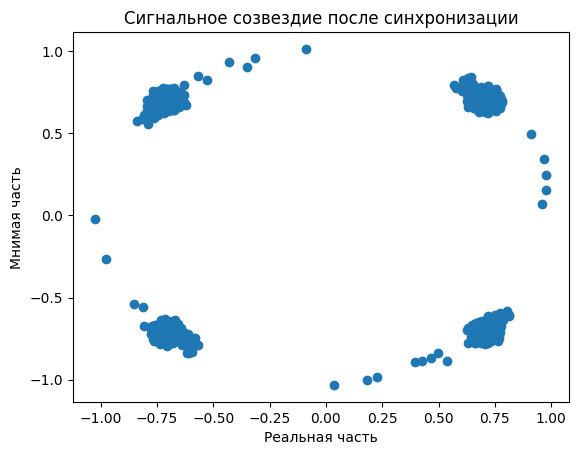

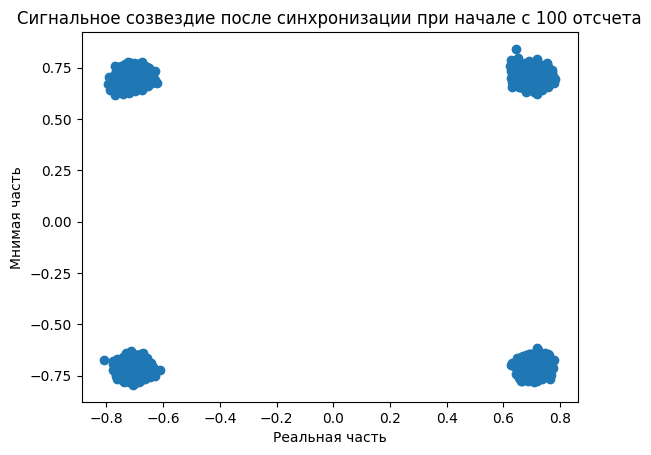

In [63]:
def phase_detector_QPSK(sample):
    ref_point = [np.sqrt(2)/2+(np.sqrt(2)/2)*1j, np.sqrt(2)/2-(np.sqrt(2)/2)*1j, -np.sqrt(2)/2-(np.sqrt(2)/2)*1j, -np.sqrt(2)/2+(np.sqrt(2)/2)*1j]
    distance = np.abs(sample - ref_point)
    ind_min = np.argmin(distance)
    error_angle = np.angle(sample*np.conj(ref_point[ind_min])) 
    return error_angle

def Costas_Loop(tx, fs, alpha, beta):
    N = len(tx)
    phase = 0
    freq = 0
    
    out = np.zeros(N, dtype=np.complex64)
    freq_log = []
    phase_log = []
    error_log = []
    for i in range(N):
        out[i] = tx[i] * np.exp(-1j*phase) 
        error = phase_detector_QPSK(out[i]) 

        freq += (beta * error)
        phase += freq + (alpha * error)
        freq_log.append(freq * fs / (2*np.pi))
        phase_log.append(phase)
        error_log.append(error)
        
    return out


sync_data = Costas_Loop(tx, fs, alpha = 0.05, beta = 0.001)
# ERRS = []
# for i in range(len(tx)):
#     error = phase_detector_QPSK(tx[i])
#     ERRS.append(error)
# print("Среднее значение смещения фазы: ", np.round(np.mean(ERRS), decimals=3), "°")
# print("Ошибка вычисления фазы: ",np.round(np.rad2deg(offset_phase)-np.mean(ERRS), decimals=3), "°")

plt.figure(0)
plt.scatter(np.real(sync_data), np.imag(sync_data))
plt.title(f'Сигнальное созвездие после синхронизации')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")

plt.figure(1)
plt.scatter(np.real(sync_data[100:data_len]), np.imag(sync_data[100:data_len]))
plt.title(f'Сигнальное созвездие после синхронизации при начале с 100 отсчета')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")


Полученные графики показывают, что схема хорошо справляется с введенными смещениями. Однако, схеме требуется время для подстройки. Если построить сигнальное созвездие, начиная с 100 отсчета, то оно не будет иметь "хвостов".

### 9. Анализ схемы ML data-aided phase estimation

В данном разделе исследована зависимость модуля величины ошибки вычисления фазового смещения от SNR. 
По графику видно, что с увеличением отношения сигнал/шум ошибка оценки фазы уменьшается по экспоненциальному закону.

Text(0, 0.5, 'Ошибка оценки фазового смещения')

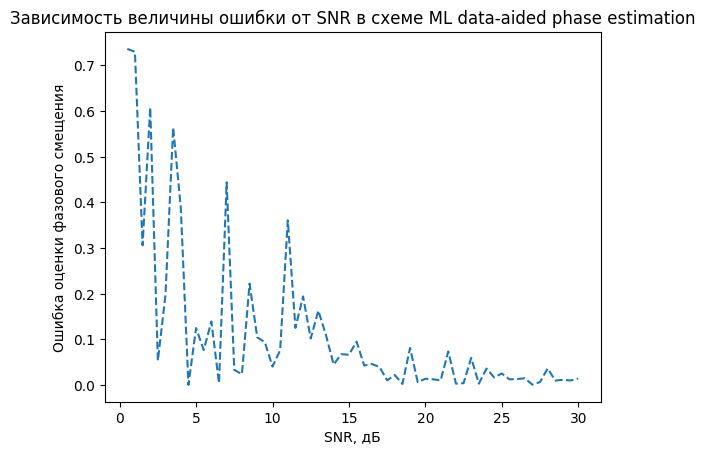

In [64]:
ERRS_ML = [] 

for i in range(1, 61, 1):
    awgn_noise = awgn(data_mod_phaseof, i/2)
    tx = data_mod_phaseof + awgn_noise
    PHASE_EST = np.array([]) 
    PHASE_EST = ml_est(tx, data_mod, PHASE_EST)
    err = np.rad2deg(offset_phase)-np.mean(PHASE_EST)
    ERRS_ML.append(err)


plt.figure(0)
snrs = np.arange(1, 61)
plt.plot(snrs/2, np.abs(ERRS_ML), '--')
plt.title('Зависимость величины ошибки от SNR в схеме ML data-aided phase estimation')
plt.xlabel('SNR, дБ')
plt.ylabel('Ошибка оценки фазового смещения')

### 10. Анализ схемы петли Костаса
Поскольку за результат работы схемы было принято подстроенное созвездие, дальнейший анализ производится по графикам сигнальных созвездий.

В первую очередь, получены созвездия при разных значениях уровня шума. Очевидно, что с увеличением отношения сигнал/шум, восстановление сигнала улучшается. Начиная с 10 дБ созвездие можно считать различимым, однако даже при высоких значениях SNR остаются точки, связанные с подстройкой схемы.  

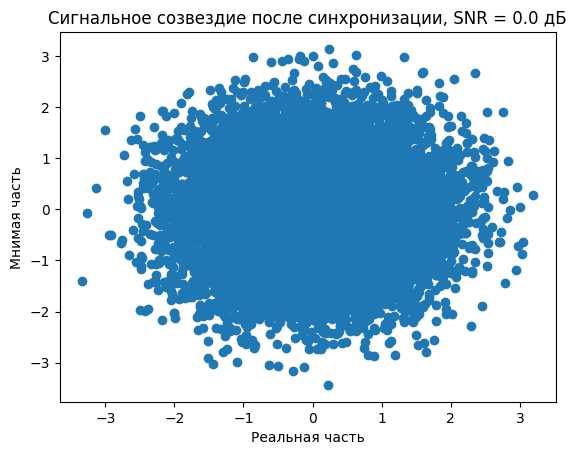

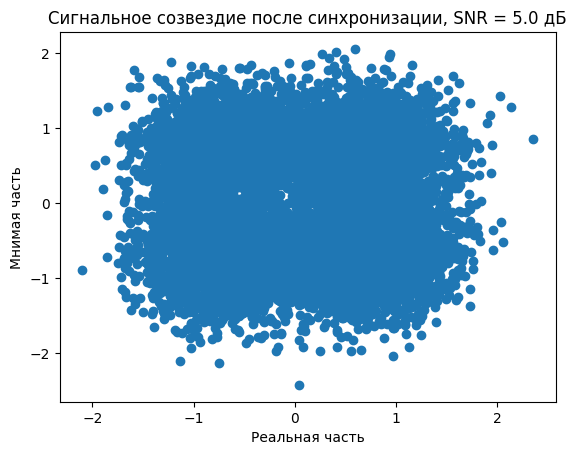

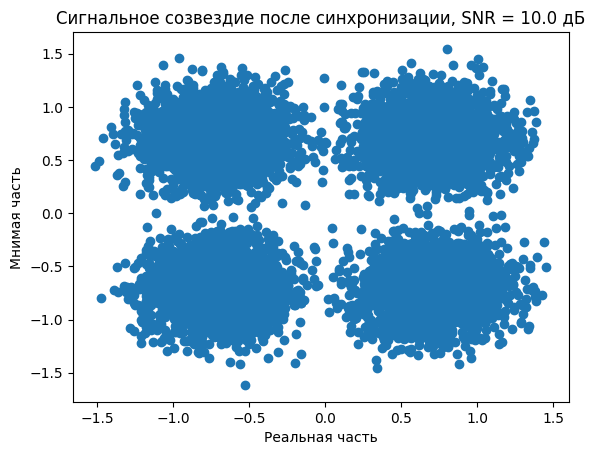

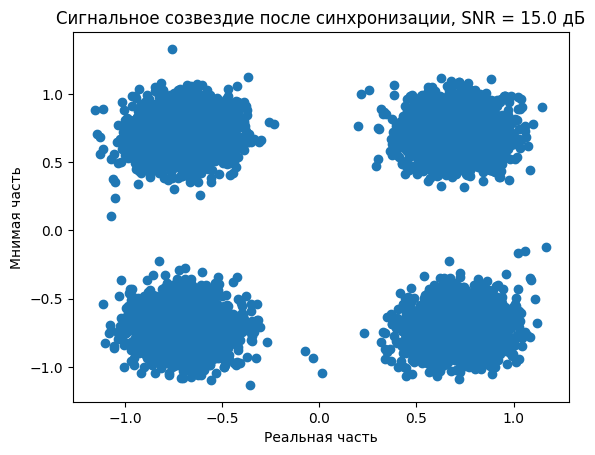

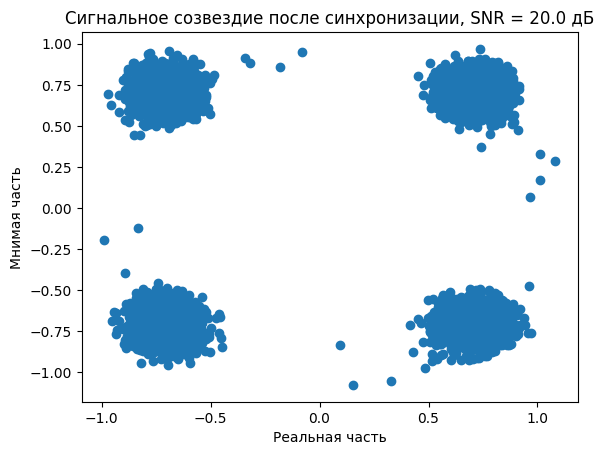

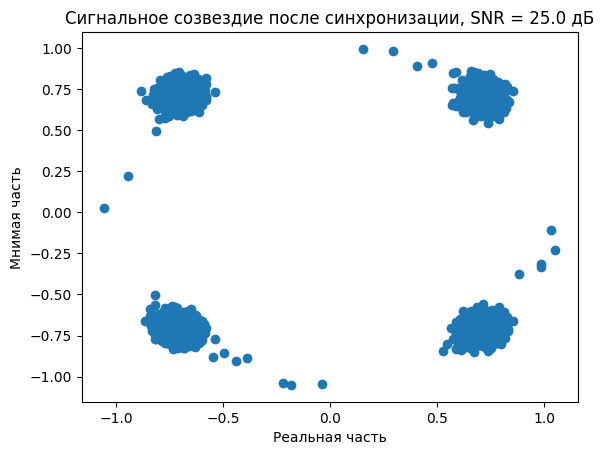

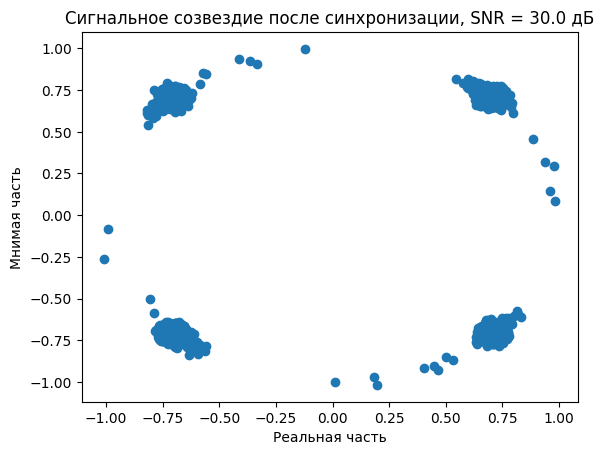

In [65]:
for i in range(0, 61, 1):
    awgn_noise = awgn(data_mod_phaseof, i/2)
    tx = data_mod_phaseof + awgn_noise
    sync_data = Costas_Loop(tx, fs, alpha = 0.05, beta = 0.001)
    if i % 10 == 0: 
        plt.figure(i)
        plt.scatter(np.real(sync_data), np.imag(sync_data))
        plt.title(f'Сигнальное созвездие после синхронизации, SNR = {i/2} дБ')
        plt.ylabel("Мнимая часть")
        plt.xlabel("Реальная часть")



Далее было проанализировано влияние параметров alpha и beta, применяющихся в петле Костаса, на созвездие на выходе схемы. SNR выбран равным 30 дБ.  
Оценивая результаты, полученные на графиках, можно сделать вывод, что увеличение alpha от значения 1e-3 к 1 приводит к заметному уменьшению времени подстройки. Увеличение параметра beta от значения 1e-3 к 1 привело, наоборот, к ухудшению результата: увеличилось количество ошибок. Таким образом, компромиссным выбором коэффициентов для данной схемы является alpha = 1, beta = 0.001. 

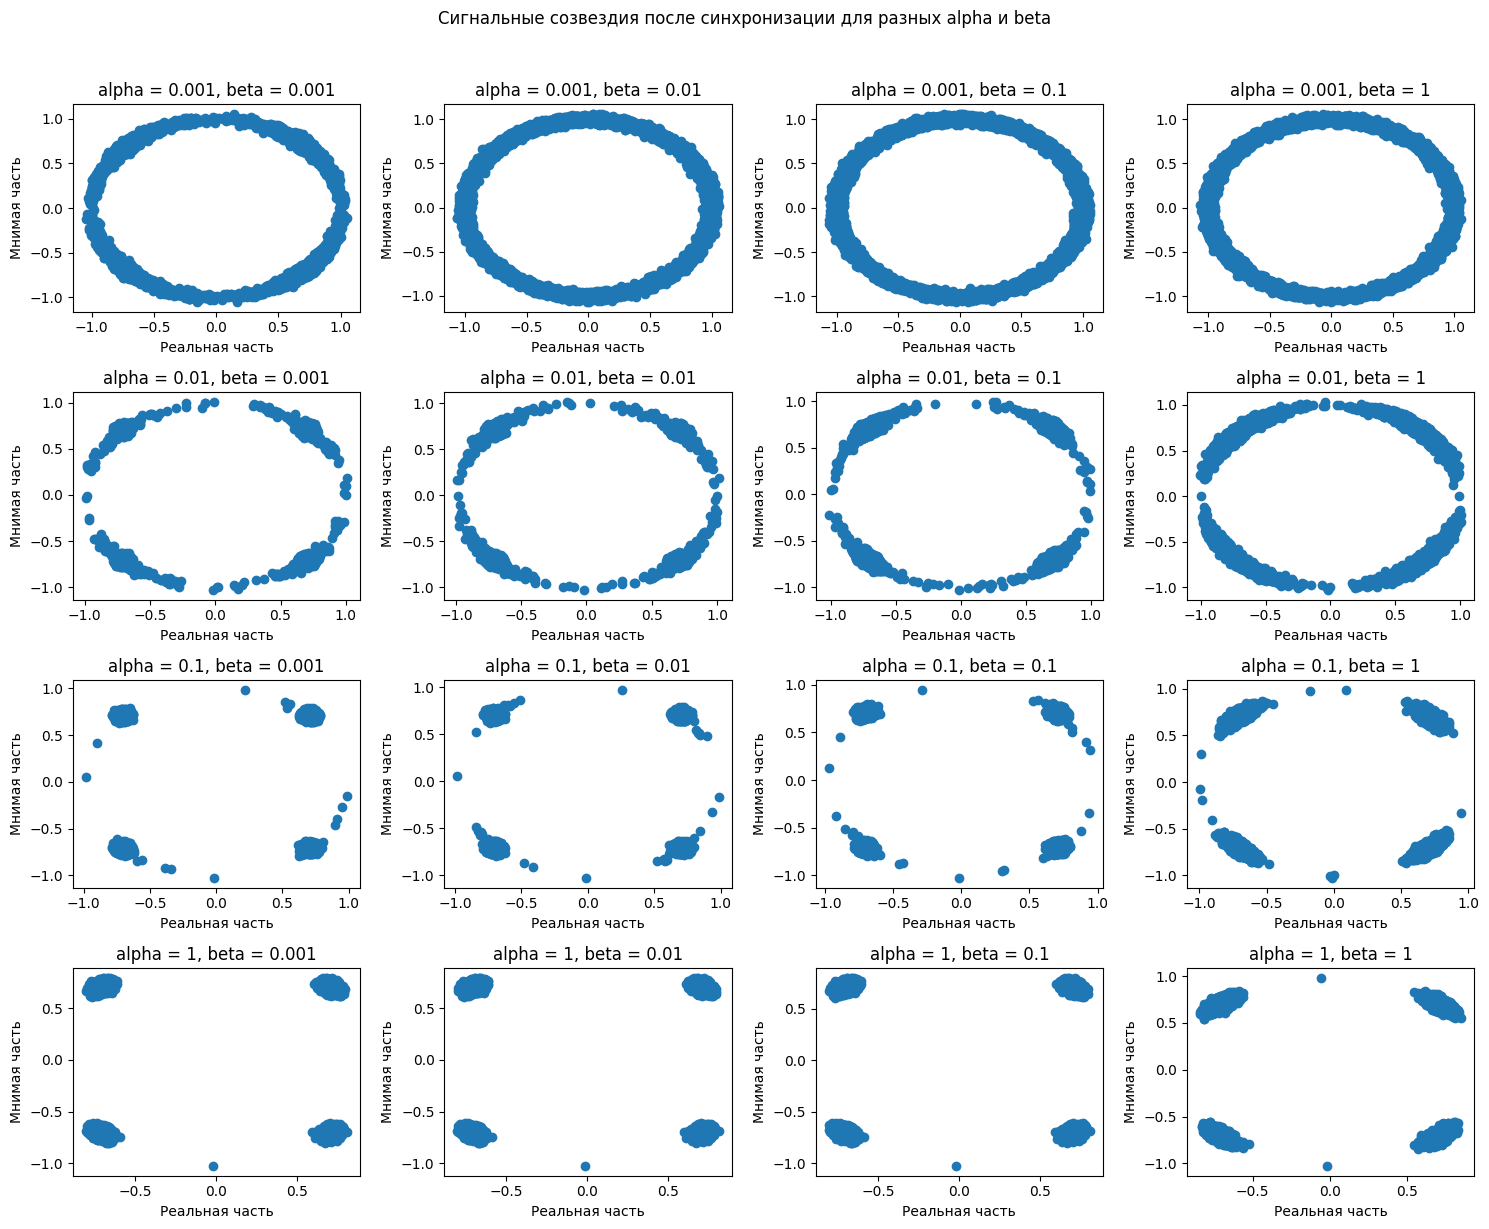

In [66]:
awgn_noise = awgn(data_mod_phaseof, snr)
tx = data_mod_phaseof + awgn_noise

alpha = [1e-3, 1e-2, 1e-1, 1]
beta = [1e-3, 1e-2, 1e-1, 1]

# Создаем фигуру с subplot'ами
fig, axs = plt.subplots(len(alpha), len(beta), figsize=(15, 12))
fig.suptitle('Сигнальные созвездия после синхронизации для разных alpha и beta', y=1.02)

for i, alpha_i in enumerate(alpha):
    for j, beta_i in enumerate(beta):
        sync_data = Costas_Loop(tx, fs, alpha=alpha_i, beta=beta_i)
        
        # Рисуем scatter plot на соответствующем subplot'е
        axs[i, j].scatter(np.real(sync_data), np.imag(sync_data))
        axs[i, j].set_title(f'alpha = {alpha_i}, beta = {beta_i}')
        axs[i, j].set_ylabel("Мнимая часть")
        axs[i, j].set_xlabel("Реальная часть")

# Регулируем расстояние между subplot'ами
plt.tight_layout()
plt.show()


## Вывод

В результате выполнения лабораторной работы построены и проанализированы две схемы, компенсирующие фазовый и частотный сдвиг.  
Первая схема ML data-aided phase estimation оценивает значение угла отклонения фазы, поэтому для нее была исследована зависимость модуля величины ошибки вычисления фазового смещения от SNR. В результате было определено, что с увеличением отношения сигнал/шум ошибка оценки фазы уменьшается по экспоненциальному закону.  
Вторая схема включала петлю Костаса с фазовым детектором, вычисляющим разность фаз между входным отсчетом и ближайшей опорной точкой созвездия. Схема была исследована на для различных значений шума. Очевидно, что с увеличением SNR результат на выходе становился лучше. Начиная с 10 дБ, количество ошибок на выходе достаточно мало, однако даже при высоких значениях SNR остаются ошибочные точки, связанные с подстройкой схемы. Затем для данной схемы было оценено влияние параметров alpha и beta, заменяющих петлевой фильтр, на результаты подстройки. Увеличение alpha от значения 1e-3 к 1 сокращало время подстройки. Увеличение параметра beta от значения 1e-3 к 1 увеличило количество ошибок.